In [42]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import scipy as sp
import pandas as pd
import tqdm as tm
import torch.nn.functional as F
from functools import partial

# from sklearn.decomposition import TruncatedSVD as psvd
# import plotly.express as px
# from torch import nn
# from torch.utils.data import DataLoader
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# from numpy import random as rd
# from numpy import arange as seq
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [43]:
class Settings:
    def __init__(self, time, nodes, latent_space_dim, groups, parameter_vec, starting_lat_parameter_mat):
        self.time = time
        self.nodes = nodes
        self.latent_space_dim = latent_space_dim
        self.groups = groups
        self.parameter_vec = parameter_vec
        self.starting_lat_parameter_mat = starting_lat_parameter_mat
        self.constraint = self.gen_constraint()
        self.parameter_mat = self.gen_beta_mat()
        self.rand_initialization = self.gen_init()

    def gen_constraint(self):
        p = self.latent_space_dim
        temp = torch.cat([torch.eye(p-1), -torch.ones(p-1).unsqueeze(0).T], dim = 1)
        temp = temp.reshape(-1)
        core = torch.kron(torch.eye(3), temp).T
        right = torch.zeros(core.shape[0], 1)
        bot = torch.cat([torch.tensor([0,0,0,1.0]).unsqueeze(0)]*(p-1), dim = 0)
        bot = torch.cat([bot, torch.ones(4).unsqueeze(0)])
        A = torch.cat((torch.cat((core, right), dim = 1), bot), dim = 0)
        return(A)
    
    def gen_beta_mat(self):
        p = self.latent_space_dim
        parameter_mat = (self.constraint @ self.parameter_vec).reshape(3 * (p-1)+1, p)
        return(parameter_mat)
    
    def gen_init(self):
        n = self.nodes
        K = self.groups
        prev_state =  torch.random.get_rng_state()
        torch.manual_seed(42069)
        init_dist = Uniform(0.2, 0.8)
        init = init_dist.sample((n*K,)).reshape(n, 3)
        torch.random.set_rng_state(prev_state)
        return(init)


    def change_node(self, new_nodes):
        self.nodes = new_nodes
        self.rand_initialization = self.gen_init()

    def change_init_distr(self, new_parameter):
        self.starting_lat_parameter_mat = new_parameter
        
    def change_parameter_vec(self, new_vec):
        self.parameter_vec = new_vec
        self.parameter_mat = self.gen_beta_mat()



def proj_beta(B, constraint):
    A = constraint
    return(torch.linalg.solve(A.T @ A, A.T) @ B.reshape(-1))

def lat_vis(df, LB, col):
    sns.scatterplot(x = df[:, 0], y = df[:, 1], s = 1, color = col)
    plt.xlim(LB, 1)
    plt.ylim(LB, 1)
    plt.axvline(x=0, color = "red")
    plt.axhline(y=0, color = "red")
    plt.plot([0,1], [1,0], color = "red")
    plt.gca().set_aspect('equal')
    # plt.savefig(fr"C:\Users\yangs\Desktop\making gif\scatterplot_{idx}.png")
    # plt.close()
    

In [44]:
N, n, p, K = 2, 3000, 3, 3
current_settings = Settings(time = N,
                nodes = n,
                latent_space_dim = p,
                groups = K, 
                parameter_vec = torch.tensor([1,2,-2,5.0]),
                starting_lat_parameter_mat = torch.tensor([[1, 1, 10], [1, 10, 1], [10, 1, 1]], dtype= torch.float).reshape(K, p))

In [45]:
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#To generate
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################

def init_Z(cs = current_settings):
    nk = int(cs.nodes/cs.groups)
    init_dist = Dirichlet(cs.starting_lat_parameter_mat)
    init_samp = init_dist.sample((nk,)).transpose(0,1).reshape(cs.groups*nk, cs.latent_space_dim)
    return(init_samp)

def gen_Y(Z):
    n, p = Z.shape
    #take out the last dimension to deal with linear dependency
    Z_s = Z[:, :(p-1)].to(device)      

    #generate the parameter probability matrix from the latent positions, since the proceeding adj matrix has to be symmetric, we only keep the upper triangular portiion.
    P = torch.matmul(Z_s, Z_s.T).triu(diagonal = 1)     

    #sampling form the Bernoulli distributions as defined by P. we choose the 0th element because sampling returns a [1 x n x n] tensor
    Y_half = Bernoulli(P).sample((1,))[0]
    #symmetricize the adjacency matrix       
    Y = Y_half + Y_half.T
    
    del(Z_s, P, Y_half)

    Y = Y.to("cpu")
    torch.cuda.empty_cache() 

    return(Y)

def gen_X(Y, Z, cs = current_settings):
    Y = Y.to(device)
    n, p = Z.shape
    nk = int(n/cs.groups)
    
    Z_s = Z[:, :(p-1)].to(device)

    #within-group indicator matrix -- jth element of ith row is 1 IF j and i has the same group membership
    wthin_g = torch.kron(torch.eye(cs.groups), torch.ones(nk, nk)).to(device)
    #between-group indicator matrix       
    btwn_g  = (-1)*(wthin_g - 1)        

    Y1 = (Y * wthin_g)
    Y2 = (Y * btwn_g)

    all_ones = torch.ones(n,1).to(device)

    #take row/col sums of within/between group adjacency matrix -- this will be the scaling factor
    S1 = torch.max(all_ones, torch.sum(Y1, 1, True)).repeat(1, (p-1))       
    S2 = torch.max(all_ones, torch.sum(Y2, 1, True)).repeat(1, (p-1))

    A1 = Y1.matmul(Z_s)/S1
    A2 = Y2.matmul(Z_s)/S2

    X = torch.cat((Z_s, A1, A2, all_ones), 1)

    
    X = X.to("cpu")
    del(Z_s, wthin_g, btwn_g, Y1, Y2, all_ones, S1, S2, A1, A2)
    torch.cuda.empty_cache()

    return(X)

def next_Z(Y, Z, cs = current_settings):

    parameter_mat = cs.parameter_mat.to(device)

    Y = Y.to(device)
    Z = Z.to(device)
    X = gen_X(Y, Z, cs).to(device)

    alpha = torch.exp(X.matmul(parameter_mat))
    samp = Dirichlet(alpha).sample((1,))[0]

    samp = samp.to("cpu")
    del(Y, Z, X, alpha)
    torch.cuda.empty_cache()
    
    return(samp)



In [46]:
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#To estimate with oracle
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################

def grad_dir_reg(predictor, response, reg_parameter, cs = current_settings):
    n, p = response.shape

    predictor = predictor.to(device)
    alpha = torch.exp(torch.matmul(predictor, reg_parameter.to(device))).to(device)
    full_alpha = torch.stack([alpha.reshape(-1)]*(cs.constraint.shape[1]), dim = 1)
    # check the K parameter here, might just be a 4

    predictor = torch.kron(predictor.to(device), torch.eye(p).to(device)).to_sparse()
    response = response.to(device)
    predictor_mod = torch.sparse.mm(predictor, cs.constraint.to(device))

    digamma_alpha_sum = torch.digamma(torch.sum(alpha, axis = 1))
    mean_log = torch.digamma(alpha) - torch.stack([digamma_alpha_sum]*p).T


    bias_log = (torch.log(response) - mean_log.to(device)).reshape(-1) 


    grad = bias_log.matmul(predictor_mod * full_alpha)

    

    grad = grad.to("cpu")

    del(predictor, response, predictor_mod, alpha, full_alpha, digamma_alpha_sum, mean_log, bias_log)
    torch.cuda.empty_cache()
    return(grad)

def fish_dir_reg(predictor, response, reg_parameter, cs = current_settings):

    n, p = response.shape
    
    predictor = predictor.to(device)
    alpha = torch.exp(torch.matmul(predictor, reg_parameter.to(device))).to(device)
    full_alpha = torch.stack([alpha.reshape(-1)]*(cs.constraint.shape[1]), dim = 1)

    predictor = torch.kron(predictor, torch.eye(p).to(device)).to_sparse()
    response = response.to(device)
    predictor_mod = torch.sparse.mm(predictor, cs.constraint.to(device))

    p1 = predictor_mod * full_alpha
   
    var_p1 = torch.diag(torch.polygamma(1, alpha).reshape(-1)).to_sparse()

    var_p2 = torch.kron(torch.diag(torch.polygamma(1, torch.sum(alpha, axis = 1))), torch.ones(p, p).to(device)).to_sparse()
   
    var_dir = var_p1 - var_p2

    fish = p1.T.matmul(torch.sparse.mm(var_dir, p1))

    fish = fish.to("cpu")


    del(predictor, response, predictor_mod, alpha, full_alpha, p1, var_p1, var_p2, var_dir)
    torch.cuda.empty_cache()
    return(fish)

def Dir_NGD(predictor, response, initial_estimate_mat, cs = current_settings, tolerance = 0.001):

    n, p = response.shape

    temp = torch.cat((response, predictor), dim = 1)
    indicator = (temp > 0) & (temp <= 1)
    filtered = temp[indicator.all(dim = 1)]
    response, predictor = filtered[:,:p], filtered[:,p:]
    n_new = response.shape[0]

    next_estimate = initial_estimate_mat
    go = True
    i = 1
    while go:
    
        current_gradient = grad_dir_reg(predictor, response, next_estimate, cs)
     
        current_fisher_info = fish_dir_reg(predictor, response, next_estimate, cs)
    
        step = torch.linalg.solve(current_fisher_info, current_gradient)
        
        next_estimate = next_estimate + (cs.constraint.matmul(step)).reshape(3*(p-1)+1, p)

        go = (torch.norm(step, p = "fro") > tolerance)
        
        i += 1
        if i > 100:
            return(initial_estimate_mat*0)
        
    result_dic = {"final_estimate" : next_estimate, "final_fisher_info": current_fisher_info, "ASE_info_lost": (1 - n_new/n)}

    return(result_dic)

def Dir_Linear_Initialization(predictor, response, added_est_int = -10,  tolerance = 0.1):

    n, p = response.shape
    pred = predictor[:, :(3*(p-1))]


    temp = torch.cat((response, pred), dim = 1)
    indicator = (temp > 0) & (temp <= 1)
    filtered = temp[indicator.all(dim = 1)]
    response, pred = filtered[:,:p], filtered[:,p:]
    n_new = response.shape[0]

    H = torch.linalg.solve((pred.T @ pred), pred.T)

    constraint_no_int = torch.kron(torch.eye(3), torch.tensor([[1,0,-1,0,1,-1]])).T

    first_estimate_no_int = H.matmul(torch.log(response))

    def new_response(estimate_no_int):
        estimate_core = proj_beta(estimate_no_int, constraint_no_int)

        L = torch.tensor([0, 0, torch.sum(estimate_core)])
        exp_lambda = torch.exp(L).repeat(p,1).T

        new_response = torch.log(response) + torch.log( torch.exp(pred @ estimate_no_int) @ exp_lambda ) - L.repeat(n_new, 1)
        return(new_response)

    current_estimate = first_estimate_no_int

    current_response = response
    go = True
    i = 1
    while go and i < 100:
        current_response = new_response(current_estimate)

        new_estimate = H @ current_response

        change = torch.norm(proj_beta((new_estimate - current_estimate), constraint_no_int), p = "fro")
        current_estimate = new_estimate
        go = change > tolerance
        i += 1
    
    result = torch.cat((proj_beta(current_estimate, constraint_no_int), torch.tensor([added_est_int])))
    
        
    return(result)


In [47]:
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#Alignment
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################

#regular ASE
def ASE(A, embed_dim):
    temp_svd = torch.svd_lowrank(A, q = embed_dim)
    temp_ASE = temp_svd[0] @ torch.diag(torch.sqrt(temp_svd[1]))
    return(temp_ASE)

#orthogonal procrustes used to align the ASE with the real latent position (or a reasonably estimated one)
def orthogonal_procrustes(reference, need_embed_align, dim, ortho_mat = False):
    n, p = reference.shape
    reference = reference[:, : (p - 1)]

    t1, t2 = need_embed_align.shape
    #when t1 = t2, then need_embed_align is an adjacency matrix, embed it first
    if t1 == t2:
        ASE_need_align = ASE(need_embed_align, dim)  # Assuming ASE is defined elsewhere
    #otherwise, we have some latent positions that needs to be aligned
    else: 
        ASE_need_align = need_embed_align[:, :(p-1)]
        

    # Perform partial SVD (dim = (p-1)) on the product of the matrices, since latent position has rank (p-1)
    LRsvd_ASE = torch.svd_lowrank(ASE_need_align.T @ reference, q = (p-1))

    # Calculate the rotation matrix
    procrustes_sol = LRsvd_ASE[2] @ LRsvd_ASE[0].T

    # # same code but uses full_svd
    # svd_ASE = torch.svd(ASE_need_align.T @ reference)
    # procrustes_sol = svd_ASE.V @ svd_ASE.U.T
    
    # Apply the rotation to the aligned matrix
    aligned_ASE = ASE_need_align @ procrustes_sol.T
    last_dim = 1 - torch.sum(aligned_ASE, axis = 1).unsqueeze(1)
    aligned_ASE_full = torch.cat((aligned_ASE, last_dim), dim = 1)

    if ortho_mat:
        return procrustes_sol.T
    
    return aligned_ASE_full 



#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#Alignment Non-negative Constraint
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################;
"""
Solves the problem  min ||(A-XX^T)*M||_F^2 without any constraint on X,
by classical gradient descent.
Here * is the entry-wise product.

Parameters
----------
A : matrix nxn
X : initialization
M : mask matrix nxn
tol: tolerance used in the stop criterion  
    
Returns
-------
Matrix X
    solution of the embedding problem
"""
def GD_RDPG(A,X, L, tol=1e-3):

    n = A.shape[0]
    M = torch.ones(n, n) - torch.diag(torch.ones(n))
    M, A, X = M.to(device), A.to(device), X.to(device)

    X = X[:, :2]

    def gradient(A,X,M):

        gd = 2 * torch.matmul(( -torch.mul((M.T+M), (A)) + torch.mul((M.T+M), torch.matmul(X, X.T))), X)
        gd = gd + L*(-1)*(X < 0)
        # rowsum_X_ind = (torch.sum(X, axis = 1) > 1) * 1.0
        # gd = gd + 50*torch.cat([rowsum_X_ind.unsqueeze(0)] * 2, dim=0).T

        return gd
    
    def cost_function(A,X,M):

        cost = 0.5 * torch.norm((A - torch.matmul(X, X.T)) * M, p='fro')**2 
        cost = cost + L*torch.sum(-X[X<0])

        # rowsum_X = torch.sum(X, axis = 1)
        # cost = cost + 50*torch.sum(rowsum_X[rowsum_X > 1])

        cost = cost.to("cpu")
        torch.cuda.empty_cache()
        return cost


    b=0.3; sigma=0.1 # Armijo parameters
    rank = X.shape[1]
    max_iter = 200*rank
    t = 0.1
    Xd=X
    k=0
    last_jump=1
    d = -gradient(A,Xd,M)
    tol = tol*(torch.norm(d))
    while (torch.norm(d) > tol) & (last_jump > 1e-16) & (k<max_iter):

        # Armijo
        while (cost_function(A, Xd+t*d, M) > cost_function(A, Xd, M) - sigma*t*torch.norm(d)**2):
            t=b*t

        Xd = Xd+t*d
        last_jump = sigma*t*torch.norm(d)**2
        t=t/(b)
        k=k+1
        d = -gradient(A,Xd,M)

    Xd = Xd.to("cpu")
    del(M, A, X, d)
    torch.cuda.empty_cache()

    last_dim = 1 - torch.sum(Xd, axis = 1).unsqueeze(1)
    aligned_ASE_full = torch.cat((Xd, last_dim), dim = 1)

    return(aligned_ASE_full)


In [48]:
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#Riemannian Gradient Descent on O(p)
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################

class Op_Riemannian_GD:
    def __init__(self, data, mode, softplus_parameter = 80,tolerance = 0.01):

        self.data = data
        self.tolerance = tolerance
        self.mode = mode
        self.smoothing = softplus_parameter
        self.relu_loss = self.simplex_loss_relu(self.data)
        self.softplus_loss = self.simplex_loss_softplus(self.data, self.smoothing)
        # self.align_mat = self.GD()

    def update_parameter(self, smoothing, tolerance):

        self.smoothing = smoothing
        self.tolerance = tolerance

    @staticmethod
    def simplex_loss_relu(data_set):

        X = data_set
        relu = torch.nn.ReLU()

        negativity_loss = torch.sum(relu(-X))

        row_sum_minus_1 = torch.sum(X, dim = 1) - 1
        simp_loss = torch.sum(relu(row_sum_minus_1))

        return(negativity_loss + simp_loss)
    
    @staticmethod
    def simplex_loss_softplus(data_set, smoothing):

        X = data_set
        mu = smoothing

        softplus = torch.nn.Softplus(beta = mu)

        negativity_loss = torch.sum(softplus(-X))

        row_sum_minus_1 = torch.sum(X, dim = 1) - 1
        simp_loss = torch.sum(softplus(row_sum_minus_1))

        return(negativity_loss + simp_loss)
    
    def deriv_W_relu(self, W):

        X = self.data
        n, p = X.shape

        signs_1 = (-X @ W > 0) * 1.
        deriv_neg = -X.T @ torch.relu(signs_1)

        sign_2 = ((torch.sum(X @ W,  dim = 1) - 1) > 0) * 1.
        deriv_simp = X.T @ torch.relu(sign_2.unsqueeze(dim = 1)) @ torch.ones((1,p))

        return(deriv_neg + deriv_simp)
    
    def deriv_W_softplus(self, W):

        X = self.data
        n, p = X.shape
        
        mu = self.smoothing

        T0 = torch.exp(-mu* X @ W)
        deriv_neg = -X.T @ (T0/(1 + T0))

        row_sum_minus_1 = torch.sum(X @ W, dim = 1) - 1

        T1 = torch.exp(mu * row_sum_minus_1.unsqueeze(dim = 1))
        deriv_simp = X.T @ (T1/(1 + T1)) @ torch.ones((1, p))

        return(deriv_neg + deriv_simp)
    
    def proj_skew_sym_at_W(self, M, W):

        projection = W @ (W.T @ M - M.T @ W)/2

        return(projection)

    def matrix_exp_at_W(self, xi, W):

        Exp_w_xi = W @ torch.matrix_exp(W.T @ xi)

        return(Exp_w_xi)
    
    def GD_one_step(self, prev_position, step):
        
        W_old = prev_position

        W_old = W_old * torch.sqrt(1/(W_old @ W_old.T)[0,0])
        
        if self.mode == "relu":
            euclid_deriv = self.deriv_W_relu(W_old)
        else:
            euclid_deriv = self.deriv_W_softplus(W_old)
        
        tangent_deriv = self.proj_skew_sym_at_W(euclid_deriv, W_old)

        W_new = self.matrix_exp_at_W(-step*tangent_deriv, W_old)
        
        return(W_new)
    
    def GD_Armijo(self):

        X = self.data
        n, p = X.shape
        W = torch.eye(p)

        if self.mode == "relu":
            grad = self.deriv_W_relu
            cost = self.simplex_loss_relu
        else:
            grad = self.deriv_W_softplus
            cost = partial(self.simplex_loss_softplus, smoothing = self.smoothing)
        
        b = 0.3; sigma = 0.1
        max_iter = 10 * p

        iter = 1
        go = True
        while go:
            
            t = 0.01
            k = 1
            while (cost(X @ self.GD_one_step(W, t)) > cost(X @ W) - sigma * t * torch.norm(grad(W))):
                t = t * (b**k)
                k += 1

            W = self.GD_one_step(W, t)
            jump = sigma * t * torch.norm(grad(W))

            
            go = (torch.norm(grad(W)) > self.tolerance) & (jump > 10e-16) & (iter < max_iter)
            iter += 1

        return(W)
            


In [49]:
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#For easier simulation
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
class PAIRs:
    def __init__(self, settings, oracle = False, two_crutch = False, no_crutch = False):
 
        self.settings = settings
        self.initialization = settings.rand_initialization

        self.lat_0 = init_Z(self.settings)
        self.adj_0 = gen_Y(self.lat_0)

        self.lat_1 = next_Z(self.adj_0, self.lat_0, self.settings)
        self.adj_1 = gen_Y(self.lat_1)

        #the oracle stuff
        if oracle:
            self.pred_ora = gen_X(Y = self.adj_0, 
                                Z = self.lat_0)
            self.resp_ora = self.lat_1


        #the two-crutch stuff
        if two_crutch:
            lat_cru_0 = orthogonal_procrustes(reference=self.lat_0,
                                                need_embed_align=self.adj_0,
                                                dim = (self.settings.latent_space_dim - 1))
            self.pred_cru = gen_X(Y = self.adj_0, 
                                Z = lat_cru_0)
            self.resp_cru = orthogonal_procrustes(reference = self.lat_1,
                                            need_embed_align = self.adj_1,
                                            dim = (self.settings.latent_space_dim - 1))
        
        #the convalescent stuff
        if no_crutch:
            lat_con_0 = GD_RDPG(self.adj_0, 
                                    X = self.initialization,
                                    L = 40)
            self.pred_noc = gen_X(Y = self.adj_0, 
                                Z = lat_con_0)
            self.resp_noc = GD_RDPG(self.adj_1,
                                    X = lat_con_0, 
                                    L = 40)


In [50]:
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################
#Actual simulation
#########################################################################################################################################################################
#########################################################################################################################################################################
#########################################################################################################################################################################

def dir_reg_simulation(number_of_nodes, cs = current_settings):

    non_specifics = ["seed", "nodes", "cru_2_info_lost", "cru_0_info_lost"]
    
    b_len = cs.constraint.shape[1]

    actual_beta = ["beta_"+ str(i) + "_real" for i in range(1,(b_len+1))]

    L_oracle = ["L_" + "ora_" + "beta_" + str(i) + "_est" for i in range(1,b_len)]
    L_cru_2  = ["L_" + "cru_2_" + "beta_" + str(i) + "_est" for i in range(1,b_len)]
    L_cru_0  = ["L_" + "cru_0_" + "beta_" + str(i) + "_est" for i in range(1,b_len)]

    oracle_beta_est = ["ora_" + "beta_"+ str(i) + "_est" for i in range(1,(b_len+1))]
    cru_2_beta_est = ["cru_2_" + "beta_" + str(i) + "_est" for i in range(1,(b_len+1))]
    cru_0_beta_est = ["cru_0_" + "beta_" + str(i) + "_est" for i in range(1,(b_len+1))]

    oracle_fish_est = ["oracle_" + "fish_" + str(i) + "_est" for i in range(1, (b_len)**2+1)]
    cru_2_fish_est = ["cru_2_" + "fish_" + str(i) + "_est" for i in range(1, (b_len)**2+1)]
    cru_0_fish_est = ["cru_0_" + "fish_" + str(i) + "_est" for i in range(1, (b_len)**2+1)]

    colnames = non_specifics + actual_beta + L_oracle + L_cru_2 + L_cru_0 + oracle_beta_est + cru_2_beta_est + cru_0_beta_est + oracle_fish_est + cru_2_fish_est + cru_0_fish_est
    df = pd.DataFrame(columns= colnames)
    b = cs.parameter_vec
    B = cs.parameter_mat

    for i in tm.tqdm(range(len(number_of_nodes)), desc = "Processing", unit = "iteration"):
    # for i range(len(number_of_nodes)): #the version without progress bar
        torch.manual_seed(i)
        constraint = cs.constraint
        n = number_of_nodes[i]
        cs.change_node(n)

        temp = PAIRs(settings = current_settings, oracle = True, two_crutch = True, no_crutch = True)

        po = temp.pred_ora
        ro = temp.resp_ora
        pc = temp.pred_cru
        rc = temp.resp_cru
        pn = temp.pred_noc
        rn = temp.resp_noc

        oracle_results = Dir_NGD(po, ro, B, cs = cs)
        cru_2_results = Dir_NGD(pc, rc, B, cs = cs)
        cru_0_results = Dir_NGD(pn, rn, B,  cs =cs)

        L_oracle_result = Dir_Linear_Initialization(po, ro)[:3]
        L_cru_2_result = Dir_Linear_Initialization(pc, rc)[:3]
        L_cru_0_result = Dir_Linear_Initialization(pn, rn)[:3]

        oracle_beta_est_ = proj_beta(oracle_results["final_estimate"], constraint.to("cpu"))
        cru_2_beta_est_ = proj_beta(cru_2_results["final_estimate"], constraint.to("cpu"))
        cru_0_beta_est_ = proj_beta(cru_0_results["final_estimate"], constraint.to("cpu"))

        oracle_fish_est_ = oracle_results["final_fisher_info"].reshape(-1)
        cru_2_fish_est_ = cru_2_results["final_fisher_info"].reshape(-1)
        cru_0_fish_est_ = cru_0_results["final_fisher_info"].reshape(-1)

        temp = torch.cat((torch.tensor([i, n, cru_2_results["ASE_info_lost"], cru_0_results["ASE_info_lost"]], dtype = float),
                          b,
                          L_oracle_result, 
                          L_cru_2_result,
                          L_cru_0_result,
                          oracle_beta_est_, 
                          cru_2_beta_est_,
                          cru_0_beta_est_, 
                          oracle_fish_est_,
                          cru_2_fish_est_,
                          cru_0_fish_est_), dim = 0).numpy()
        temp = pd.DataFrame(temp).T
        temp.columns = colnames
        df = pd.concat([df, temp], ignore_index= True)
    return(df) 

In [51]:
# #########################################################################################################################################################################
# #########################################################################################################################################################################
# #########################################################################################################################################################################
# #Actual simulation DUPE
# #########################################################################################################################################################################
# #########################################################################################################################################################################
# #########################################################################################################################################################################

# def dir_reg_simulation(number_of_nodes, cs = current_settings):

#     non_specifics = ["seed", "nodes", "info_lost"]

#     actual_beta = ["beta_"+ str(i) for i in range(1,5)]

#     conv_est_beta = ["conv-" + "beta_"+ str(i) + "_est" for i in range(1,5)]
#     conv_est_fish = ["conv-" + "fisher_" + str(i) + "_est" for i in range(1, 17)]

#     colnames = non_specifics + actual_beta + conv_est_beta  + conv_est_fish
#     df = pd.DataFrame(columns= colnames)
#     b = cs.parameter_vec
#     B = cs.parameter_mat

#     for i in tm.tqdm(range(len(number_of_nodes)), desc = "Processing", unit = "iteration"):
#     # for i range(len(number_of_nodes)): #the version without progress bar
#         n = number_of_nodes[i]
#         torch.manual_seed(i)

#         cs.change_node(n)
#         constraint = cs.constraint
#         temp = PAIRs(settings = current_settings, convalescent = True)
#         pc = temp.pred_con
#         rc = temp.resp_con

#         convalescent_results = Dir_NGD(pc, rc, B, cs = cs)

#         convalescent_beta = proj_beta(convalescent_results["final_estimate"], constraint.to("cpu"))

#         convalescent_fish = convalescent_results["final_fisher_info"].reshape(-1)

#         temp = torch.cat((torch.tensor([i, n, convalescent_results["ASE_info_lost"]], dtype = float),
#                           b,
#                           convalescent_beta,
#                           convalescent_fish), dim = 0).numpy()
#         temp = pd.DataFrame(temp).T
#         temp.columns = colnames
#         df = pd.concat([df, temp], ignore_index= True)
#     return(df) 

In [ ]:
mat = torch.tensor([[1,1,10], [1,10,1], [10,1,1]], dtype= torch.float).reshape(K, p)  #starting parameters for latent position
# mat = torch.tensor([[36,2,27], [99,86,14], [72,18,34]], dtype= torch.float).reshape(K, p)/10
current_settings.change_init_distr(mat)


number_of_nodes = np.tile([1500, 3000, 4500, 6000, 7500, 9000, 10500, 12000], 5)
simulation_results = dir_reg_simulation(number_of_nodes, cs = current_settings)
simulation_results.to_csv(r"C:\Users\yangs\Desktop\simulation_results_0317.csv", index = False)

In [16]:
# starting_lat_parameter_mat = torch.tensor([[1,1,10], [1,10,1], [10,1,1]], dtype= torch.float).reshape(K, p)  #starting parameters for latent position
# # starting_lat_parameter_mat = torch.tensor([[36,2,27], [99,86,14], [72,18,34]], dtype= torch.float).reshape(K, p)/10
# current_settings.change_init_distr(starting_lat_parameter_mat)
# current_settings.change_node(3000)


# n = current_settings.nodes
# Z0 = init_Z(current_settings)
# Y0 = gen_Y(Z0)

# init_dist = Uniform(0.2,0.8)
# init_samp = init_dist.sample((n*K,)).reshape(n, 3)
# # init_dist = Dirichlet(torch.tensor([[ 1.,  1., 10], [ 1., 10,  1.], [10,  1.,  1.]]))
# # init_samp = init_dist.sample((int(n/K),)).reshape(n, K)

# raw_ASE_0 = ASE(Y0, 2)
# # standard = torch.kron(torch.eye(3), torch.ones(int(n/K))).T
# # # std_dist = Dirichlet(torch.tensor([[36,2,27], [99,86,14], [72,18,34]], dtype= torch.float))
# # # standard = std_dist.sample((int(n/K),)).reshape(n, K)
# # std_align = orthogonal_procrustes(standard, raw_ASE_0, 2)

# GD_est_0 = GD_RDPG(Y0, raw_ASE_0, 40, tol = 0.001)
# Procrustes_est_0 = orthogonal_procrustes(Z0, Y0, 2)

# Z1 = next_Z(Y0, Z0, current_settings)
# Y1 = gen_Y(Z1)
# GD_est_1 = GD_RDPG(Y1, GD_est_0[:,:2], 20, tol = 0.01)
# # GD_est_1 = GD_RDPG(Y1, Z0, tol = 0.01)
# Procrustes_est_1 = orthogonal_procrustes(Z1, Y1, 2)



# lat_vis(raw_ASE_0, -1, col = "green")
# lat_vis(Z0, -1, col = "green")
# lat_vis(GD_est_0, -1, col = "red")
# lat_vis(Procrustes_est_0, -1, col = "blue")


# lat_vis(GD_est_1, -0.1, col = "red")
# lat_vis(Z1, -0.1, col = "blue")

Simulation for the Riemannian GD

In [60]:
# A = torch.tensor([[1,1,10], [1,10,1], [10,1,1]], dtype= torch.float).reshape(K, 3)  #starting parameters for latent position
N, n, p, K = 2, 15000, 4, 3
# A = torch.tensor([[1, 1, 10, 1], [1, 10, 1, 1], [10, 1, 1, 1]], dtype= torch.float).reshape(K, p)  #starting parameters for latent position
A = torch.tensor([[36,2,27, 15], [99,86,14, 66], [72,18,34, 88]], dtype= torch.float).reshape(K, p)/10  #starting parameters for latent position
current_settings = Settings(time = N,
                nodes = n,
                latent_space_dim = p,
                groups = K, 
                parameter_vec = torch.tensor([1,1,-4,5.0]),
                starting_lat_parameter_mat = A)

temp = PAIRs(settings = current_settings, oracle = True, two_crutch = True, no_crutch = False)
t1 = temp.lat_0
t2 = temp.pred_cru
t3 = ASE(temp.adj_0, p-1)
# t1 = temp.lat_1
# t2 = temp.resp_cru
# t3 = ASE(temp.adj_1, p-1)


In [61]:
GD_result = Op_Riemannian_GD(t3, "softplus")

In [62]:
R = GD_result.GD_Armijo()

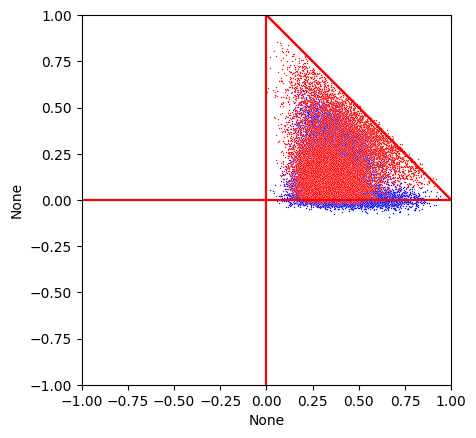

In [64]:
lat_vis(t2, -1, "blue")
lat_vis(t3 @ R, -1, "red")

In [56]:
GD_result = Op_Riemannian_GD(t3, "softplus")
R = GD_result.GD_one_step(torch.eye(p-1), 1)
GD_result.update_parameter(50, 0.1)

total_iter = 50200
tracking_gradient = []
tracking_loss = []

iteration = 50000
while iteration <= total_iter:
    R = GD_result.GD_one_step(R, 1/50000)
    tracking_gradient.append(torch.norm(GD_result.deriv_W_relu(R)))
    tracking_loss.append(GD_result.simplex_loss_relu(t3 @ R))
    iteration += 1


<Axes: >

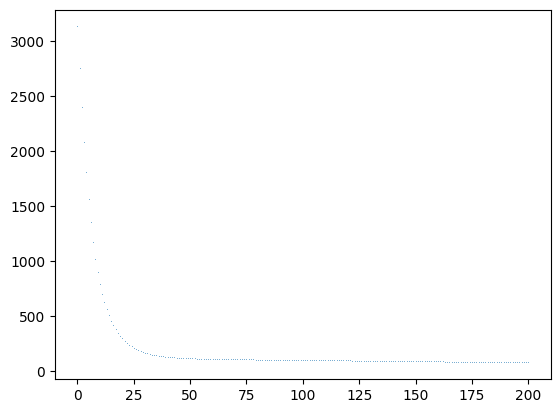

In [57]:
sns.scatterplot(x = range(len(tracking_loss)), y = (np.array(tracking_loss)), s = 0.5)

<Axes: >

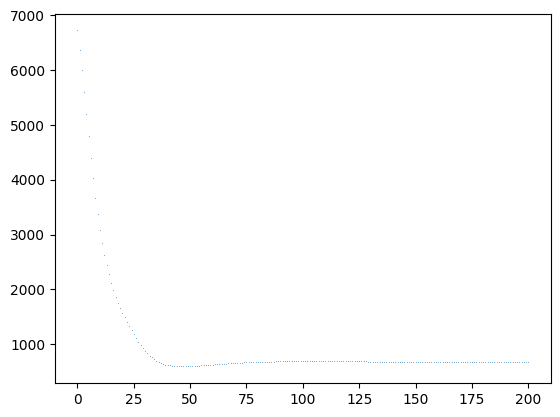

In [58]:
sns.scatterplot(x = range(len(tracking_gradient)), y = (np.array(tracking_gradient)), s = 0.5)

In [77]:
import plotly.graph_objects as go

# Sample data (replace this with your torch tensor)
data_1 = t3 @ R
data_2 = t2


vertices = [(0,0,0),(1, 0, 0), (0, 1, 0), (0, 0, 1)]

# Define the four triangular surfaces
surfaces = [
    [vertices[1], vertices[2], vertices[3]],
    [vertices[0], vertices[1], vertices[2]],
    [vertices[0], vertices[1], vertices[3]],
    [vertices[0], vertices[2], vertices[3]]

]

# Create figure
fig = go.Figure()

for surface in surfaces:
    x, y, z = surface[0], surface[1], surface[2]
    fig.add_trace(go.Mesh3d(x=x, y=y, z=z, opacity=0.5, color = "green"))



# Add 3D scatter plot
fig.add_trace(go.Scatter3d(
    x=data_1[:, 0],
    y=data_1[:, 1],
    z=data_1[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color="red",
        opacity=0.4
    )
))

fig.add_trace(go.Scatter3d(
    x=data_2[:, 0],
    y=data_2[:, 1],
    z=data_2[:, 2],
    mode='markers',
    marker=dict(
        size=1,
        color="blue",
        opacity=0.4
    )
))

# Set axes range
fig.update_layout(
    scene=dict(
        xaxis=dict(range=[-0.2, 1]),
        yaxis=dict(range=[-0.2, 1]),
        zaxis=dict(range=[-0.2, 1]),
        aspectmode='cube' 
    )
)

# Show plot
fig.show()


In [46]:
Op_Riemannian_GD(t3 @ R).simplex_loss_relu

tensor(0.)

In [47]:
Op_Riemannian_GD(t2).simplex_loss_softplus

tensor(130.7214)